## Importando bibliotecas

In [1]:
%matplotlib inline
%load_ext memory_profiler

import os
from os.path import join, getsize
import re
import urllib.request
import zipfile
import glob
import numpy as np
import matplotlib.pyplot as plt

## Preparando o dataset

In [2]:
urllib.request.urlretrieve('https://s3-sa-east-1.amazonaws.com/luizalabs-tech-challenges/movies.zip', 'movie.zip')

with open('movie.zip', 'rb') as f:
    z = zipfile.ZipFile(f)
    for name in z.namelist():
        try:
            z.extract(name, '.')
        except:
            pass

## Problema

Esse problema pode ser dividido em quatro outros sub problemas, são eles:

    * listar arquivos de uma pasta
    * procurar uma substring em um texto
    * ler o conteudo de um arquivo
    * ordenar alfabeticamente

A baixo vou atacar cada um separadamente com o objetivo de obter a forma mais performática de resolver cada um deles, tendo como objetivo a menor velocidade de execução e o menor consumo de memória.

### Listar arquivos de uma pasta

In [2]:
#usando o walk
def get_files1(path):
    _, _, files = next(os.walk(path))
    return files
    
#usando o scandir
def get_files2(path):
    return os.scandir(path)
    
#usando o glob
def get_files3(path):
    return glob.glob(join(path, '*'))
    
#usando o listdir
def get_files4(path):
    return os.listdir(path)

#### Tempo de execução

In [3]:
a1 = %timeit -r 10 -o get_files1('data')
a2 = %timeit -r 10 -o get_files2('data')
a3 = %timeit -r 10 -o get_files3('data')
a4 = %timeit -r 10 -o get_files4('data')

30.9 ms ± 2.27 ms per loop (mean ± std. dev. of 10 runs, 10 loops each)
51.5 µs ± 175 ns per loop (mean ± std. dev. of 10 runs, 10000 loops each)
85.8 ms ± 367 µs per loop (mean ± std. dev. of 10 runs, 10 loops each)
21.2 ms ± 529 µs per loop (mean ± std. dev. of 10 runs, 10 loops each)


<Container object of 4 artists>

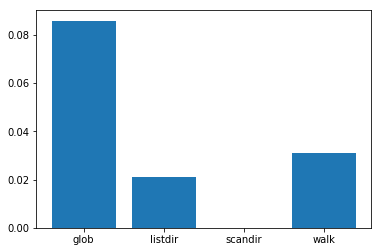

In [4]:
y = [a1.average, a2.average, a3.average, a4.average]
x = ['walk', 'scandir', 'glob', 'listdir']
plt.bar(x, y)

#### Consumo de mémoria

In [5]:
ma1 = %memit -r 10 -o get_files1('data')
ma2 = %memit -r 10 -o get_files2('data')
ma3 = %memit -r 10 -o get_files3('data')
ma4 = %memit -r 10 -o get_files4('data')

peak memory: 64.59 MiB, increment: 0.73 MiB
peak memory: 64.08 MiB, increment: 0.00 MiB
peak memory: 65.14 MiB, increment: 1.07 MiB
peak memory: 64.49 MiB, increment: 0.41 MiB


<Container object of 4 artists>

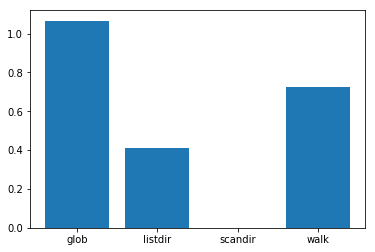

In [6]:
y = [
        max(ma1.mem_usage) - ma1.baseline, 
        max(ma2.mem_usage) - ma2.baseline, 
        max(ma3.mem_usage) - ma3.baseline, 
        max(ma4.mem_usage) - ma4.baseline, 
]

x = ['walk', 'scandir', 'glob', 'listdir']
plt.bar(x, y)

#### Conclusão

Para listar arquivos o `scandir` levou vantagem tanto no tempo de execução quanto no consumo de mémoria.

vencedor: `scandir` 

###  Procurar uma substring em um texto

In [7]:
def find_str1(content, q):
    return q in content

def find_str2(content, q):
    return content.find(q) > -1

def find_str3(content, q):
    return re.match(content, q)

#https://en.wikipedia.org/wiki/Rabin%E2%80%93Karp_algorithm
def find_str4(source, pattern):
    base = 26
    p_hash = 0
    s_hash = 0
    letter_position = lambda letter:  ord(letter) - ord('A')

    for letter in pattern:
        p_hash = p_hash * base + letter_position(letter)

    first_letter_base = base ** (len(pattern) - 1)
    for i, letter in enumerate(source):
        s_hash = s_hash * base + letter_position(letter)
        if i < len(pattern) - 1:
            continue

        match_start_index = i - len(pattern) + 1
        if s_hash == p_hash:
            return match_start_index

        s_hash = s_hash - letter_position(source[match_start_index]) *  first_letter_base
    return None


#https://en.wikipedia.org/wiki/Boyer%E2%80%93Moore_string_search_algorithm
def find_str5(text, pattern):
    m = len(pattern)
    n = len(text)
    if m > n: return -1
    skip = []
    for k in range(256): skip.append(m)
    for k in range(m - 1): skip[ord(pattern[k])] = m - k - 1
    skip = tuple(skip)
    k = m - 1
    while k < n:
        j = m - 1; i = k
        while j >= 0 and text[i] == pattern[j]:
            j -= 1; i -= 1
        if j == -1: return i + 1
        k += skip[ord(text[k])]
    return -1

#### Tempo de execução

In [8]:
content = 'Bem vindo ao desafio técnico do Luiza Labs e muito obrigado por se interessar em fazer parte do Magazine Luiza.'
q = 'obrigado'
s1 = %timeit -r 10 -o find_str1(content, q)
s2 = %timeit -r 10 -o find_str2(content, q)
s3 = %timeit -r 10 -o find_str3(content, q)
s4 = %timeit -r 10 -o find_str4(content, q)
s5 = %timeit -r 10 -o find_str5(content, q)

195 ns ± 6 ns per loop (mean ± std. dev. of 10 runs, 10000000 loops each)
353 ns ± 5.21 ns per loop (mean ± std. dev. of 10 runs, 1000000 loops each)
942 ns ± 13.1 ns per loop (mean ± std. dev. of 10 runs, 1000000 loops each)
62.3 µs ± 2.21 µs per loop (mean ± std. dev. of 10 runs, 10000 loops each)
31.6 µs ± 157 ns per loop (mean ± std. dev. of 10 runs, 10000 loops each)


<Container object of 5 artists>

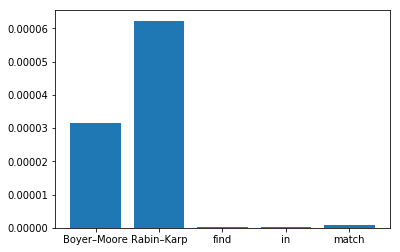

In [9]:
y = [s1.average, s2.average, s3.average, s4.average, s5.average]
x = ['in', 'find', 'match', 'Rabin–Karp', 'Boyer–Moore']
plt.bar(x, y)

#### Consumo de mémoria

In [10]:
content = 'Bem vindo ao desafio técnico do Luiza Labs e muito obrigado por se interessar em fazer parte do Magazine Luiza.'
q = 'obrigado'
ms1 = %memit -r 10 -o find_str1(content, q)
ms2 = %memit -r 10 -o find_str2(content, q)
ms3 = %memit -r 10 -o find_str3(content, q)
ms4 = %memit -r 10 -o find_str4(content, q)
ms5 = %memit -r 10 -o find_str5(content, q)

peak memory: 66.34 MiB, increment: 0.11 MiB
peak memory: 66.34 MiB, increment: 0.00 MiB
peak memory: 66.34 MiB, increment: 0.00 MiB
peak memory: 66.34 MiB, increment: 0.00 MiB
peak memory: 66.34 MiB, increment: 0.00 MiB


<Container object of 5 artists>

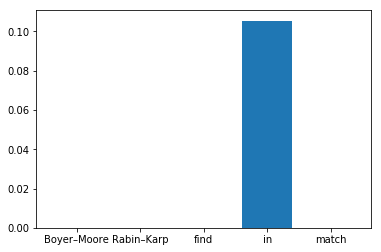

In [11]:
y = [
        max(ms1.mem_usage) - ms1.baseline, 
        max(ms2.mem_usage) - ms2.baseline, 
        max(ms3.mem_usage) - ms3.baseline, 
        max(ms4.mem_usage) - ms4.baseline, 
        max(ms5.mem_usage) - ms5.baseline, 
]

x = ['in', 'find', 'match', 'Rabin–Karp', 'Boyer–Moore']
plt.bar(x, y)

#### Conclusão

A performance desse problema esta relacionado com o tamanho do texto em que se realiza a busca. Usei os metodos nativos `in`, `find` e `match`, com a adição de mais dois algoritmos de busca em texto o `Rabin–Karp` e `Boyer–Moore`.

O método que apresentou melhor custo beneficio foi o `find`.

vencendor: `find`  

### Ler o conteudo de um arquivo 

In [12]:
#lendo o arquivo inteiro
def find1(path, q):
    with(open(path)) as f:
        content = f.read()
    return q in content


#lendo o arquivo em pedaços
def find2(path, q):
    with(open(path)) as f:
        length = len(q)
        part = f.read(length)
        
        while True:
            if part == q:
                return True

            char = f.read(1)
            
            if not char:
                return False

            part = part[1:] + char

            
#lendo o arquivo por linhas            
def find3(path, q):
     with(open(path)) as file:
        for line in file:
            if q in line:
                return True
        return False


In [13]:
#procurando o maior arquivo de nosso dataset

biggest = ('', -1)
path = 'data'

for item in os.listdir(path):
    item = join(path, item)
    itemsize = getsize(item)
    if itemsize > biggest[1]:
            biggest = (item, itemsize)

print('O maior arquivo é {} e tem {} bytes'.format(*biggest))

O maior arquivo é data\the-most-dangerous-man-in-america-daniel-ellsberg-and-the-pentagon-papers.txt e tem 170 bytes


#### Tempo de execução

In [14]:
hf1 = %timeit -r 10 -o find1('./data/the-most-dangerous-man-in-america-daniel-ellsberg-and-the-pentagon-papers.txt', 'papers')    
hf2 = %timeit -r 10 -o find2('./data/the-most-dangerous-man-in-america-daniel-ellsberg-and-the-pentagon-papers.txt', 'papers')    
hf3 = %timeit -r 10 -o find3('./data/the-most-dangerous-man-in-america-daniel-ellsberg-and-the-pentagon-papers.txt', 'papers')    


125 µs ± 9.85 µs per loop (mean ± std. dev. of 10 runs, 10000 loops each)
138 µs ± 2.34 µs per loop (mean ± std. dev. of 10 runs, 10000 loops each)
122 µs ± 12.8 µs per loop (mean ± std. dev. of 10 runs, 10000 loops each)


<Container object of 3 artists>

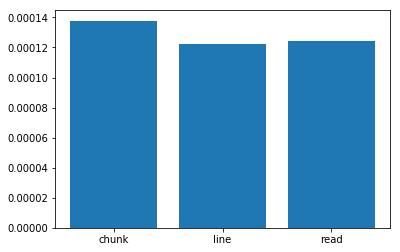

In [15]:
y = [hf1.average, hf2.average, hf3.average]
x = ['read', 'chunk', 'line']
plt.bar(x, y)

#### Consumo de mémoria

In [16]:
mhf1 = %memit -r 10 -o find1('./data/the-most-dangerous-man-in-america-daniel-ellsberg-and-the-pentagon-papers.txt', 'papers')  
mhf2 = %memit -r 10 -o find2('./data/the-most-dangerous-man-in-america-daniel-ellsberg-and-the-pentagon-papers.txt', 'papers')
mhf3 = %memit -r 10 -o find3('./data/the-most-dangerous-man-in-america-daniel-ellsberg-and-the-pentagon-papers.txt', 'papers')    

peak memory: 67.88 MiB, increment: 0.00 MiB
peak memory: 67.88 MiB, increment: 0.00 MiB
peak memory: 67.88 MiB, increment: 0.00 MiB


<Container object of 3 artists>

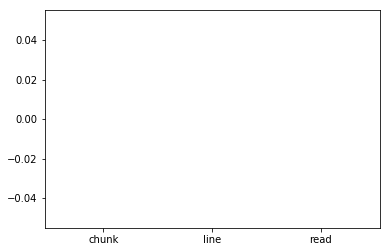

In [23]:
y = [
    max(mhf1.mem_usage) - mhf1.baseline, 
    max(mhf2.mem_usage) - mhf2.baseline, 
    max(mhf3.mem_usage) - mhf3.baseline,
]
x = ['read', 'chunk', 'line']
plt.bar(x, y)

#### Conclusão

Arquivos pequenos com pouco conteúdo podem ser carregados com o `read` de uma só vez para a mémoria. Já arquivos grandes precisam ser carregodos em pedaços (`chunks`) para que o consumo de mémoria se mantenha baixo, mas sendo penalizado com perda de velocidade. Já ler os arquivos por linhas apresenta o melhor custo beneficio, uma vez que apenas uma linha do arquivo é carregada para a mémoria por vez.

vencendor: `line`

### Ordenar alfabeticamente

In [25]:
def sort1(results):
    return sorted(results)

def sort2(results):
    results.sort()
    return results

def quicksort(arr):
    if len(arr) < 2:
        return arr

    pivot = arr[0]
    lesser = quicksort([x for x in arr if x < pivot])
    greater = quicksort([x for x in arr if x > pivot])

    return lesser + [pivot] + greater

def merge(left, right):
    if not len(left) or not len(right):
        return left or right

    result = []
    i, j = 0, 0
    while (len(result) < len(left) + len(right)):
        if left[i] < right[j]:
            result.append(left[i])
            i+= 1
        else:
            result.append(right[j])
            j+= 1
        if i == len(left) or j == len(right):
            result.extend(left[i:] or right[j:])
            break 

    return result

def mergesort(list):
    if len(list) < 2:
        return list

    middle = int(len(list) / 2)
    left = mergesort(list[:middle])
    right = mergesort(list[middle:])

    return merge(left, right)

def ins_sort(k):
    for i in range(1,len(k)):
        j = i                    
        temp = k[j]              
        while j > 0 and temp < k[j-1]: 
            k[j] = k[j-1] 
            j=j-1 
        k[j] = temp
    return k

#### Tempo de execução

In [26]:
content = 'Bem vindo ao desafio técnico do Luiza Labs e muito obrigado por se interessar em fazer parte do Magazine Luiza.'.split()
z1 = %timeit -r 10 -o sort1(content)
z2 = %timeit -r 10 -o sort2(content)
z3 = %timeit -r 10 -o quicksort(content)
z4 = %timeit -r 10 -o mergesort(content)
z5 = %timeit -r 10 -o ins_sort(content)

1.6 µs ± 56.5 ns per loop (mean ± std. dev. of 10 runs, 1000000 loops each)
557 ns ± 3.55 ns per loop (mean ± std. dev. of 10 runs, 1000000 loops each)
41.5 µs ± 295 ns per loop (mean ± std. dev. of 10 runs, 10000 loops each)
51.3 µs ± 1.44 µs per loop (mean ± std. dev. of 10 runs, 10000 loops each)
4.41 µs ± 236 ns per loop (mean ± std. dev. of 10 runs, 100000 loops each)


<Container object of 5 artists>

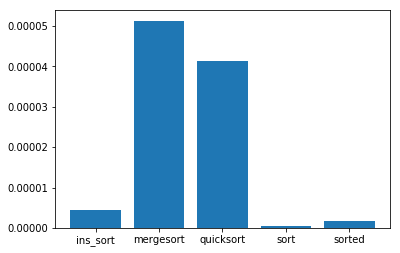

In [27]:
y = [z1.average, z2.average, z3.average, z4.average, z5.average]
x = ['sorted', 'sort', 'quicksort', 'mergesort', 'ins_sort']
plt.bar(x, y)

#### Consumo de mémoria

In [28]:
content = 'Bem vindo ao desafio técnico do Luiza Labs e muito obrigado por se interessar em fazer parte do Magazine Luiza.'.split()
mz1 = %memit -r 10 -o sort1(content)
mz2 = %memit -r 10 -o sort2(content)
mz3 = %memit -r 10 -o quicksort(content)
mz4 = %memit -r 10 -o mergesort(content)
mz5 = %memit -r 10 -o ins_sort(content)

peak memory: 71.64 MiB, increment: 0.00 MiB
peak memory: 71.64 MiB, increment: 0.00 MiB
peak memory: 71.64 MiB, increment: 0.00 MiB
peak memory: 71.64 MiB, increment: 0.00 MiB
peak memory: 71.64 MiB, increment: 0.00 MiB


<Container object of 5 artists>

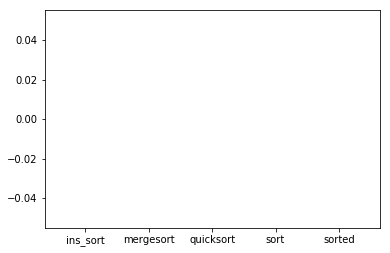

In [29]:
y = [
    max(mz1.mem_usage) - mz1.baseline, 
    max(mz2.mem_usage) - mz2.baseline, 
    max(mz3.mem_usage) - mz3.baseline,
    max(mz4.mem_usage) - mz4.baseline, 
    max(mz5.mem_usage) - mz5.baseline,
]
x = ['sorted', 'sort', 'quicksort', 'mergesort', 'ins_sort']
plt.bar(x, y)

#### Conclusão

Foram testados os método de ordenação nativos `sort`, `sorted` ambos usam o `Timsort` que é o algoritmos de ordenação padrão do python, foram adicionados mais três algoritmos o `quicksort`, `mergesort` e o `insertion sort`. As implementações nativas se mostraram superior, visto que são implementadas em C. Já entre o `sort` e o `sorted`, o primeiro levou vantagem por fazer a ordenação na propria instância da lista sem necessidade da criação de uma copia.

vencendor: `sort` 

## Soluções

Comparação entre diferentes abordagens da solução.

In [2]:
#solução simples

from search1 import search1
tsolucao1 = %timeit -r 1 -o search1('walt disney', 'data')
msolucao1 = %memit -r 1 -o search1('walt disney', 'data')

1.67 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
peak memory: 62.03 MiB, increment: 0.16 MiB


In [3]:
#solução com threads

from search2 import search2
tsolucao2 = %timeit -r 1 -o search2('walt disney', 'data')
msolucao2 = %memit -r 1 -o search2('walt disney', 'data')

1.18 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
peak memory: 63.48 MiB, increment: 0.08 MiB


In [4]:
#solução rodando em paralelo (com pool)

from search3 import search3
tsolucao3 = %timeit -r 1 -o search3('walt disney', 'data')
msolucao3 = %memit -r 1 -o search3('walt disney', 'data')

1.7 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
peak memory: 65.99 MiB, increment: 0.77 MiB


In [5]:
#solução rodando em paralelo (com fila)

from search4 import search4
tsolucao4 = %timeit -r 1 -o search4('walt disney', 'data')
msolucao4 = %memit -r 1 -o search4('walt disney', 'data')

2.22 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
peak memory: 66.11 MiB, increment: 0.70 MiB


In [6]:
#solução rodando em paralelo (com temp files)

from search5 import search5
tsolucao5 = %timeit -r 1 -o search5('walt disney', 'data')
msolucao5 = %memit -r 1 -o search5('walt disney', 'data')

1.08 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
peak memory: 66.32 MiB, increment: 0.51 MiB


In [7]:
#solução rodando em paralelo (com manager)

from search6 import search6
tsolucao6 = %timeit -r 1 -o search6('walt disney', 'data')
msolucao6 = %memit -r 1 -o search6('walt disney', 'data')

2.36 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
peak memory: 66.50 MiB, increment: 0.25 MiB


In [8]:
#solução rodando em paralelo (shared memory)

from search7 import search7
tsolucao7 = %timeit -r 1 -o search7('walt disney', 'data')
msolucao7 = %memit -r 1 -o search7('walt disney', 'data')

1.04 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
peak memory: 66.30 MiB, increment: 0.00 MiB


In [9]:
#solução rodando em paralelo (consumer)

from search8 import search8
tsolucao8 = %timeit -r 1 -o search8('walt disney', 'data')
msolucao8 = %memit -r 1 -o search8('walt disney', 'data')

1.31 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
peak memory: 66.34 MiB, increment: 0.00 MiB


In [11]:
#solução rodando em paralelo (consumer/shared memory)

from search9 import search9
tsolucao9 = %timeit -r 1 -o search9('walt disney', 'data')
msolucao9 = %memit -r 1 -o search9('walt disney', 'data')

873 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
peak memory: 66.33 MiB, increment: 0.03 MiB


#### Tempo de execução

<Container object of 9 artists>

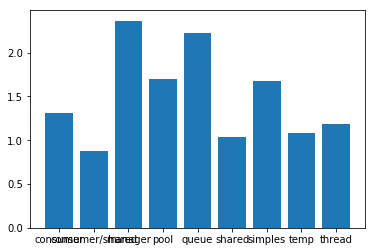

In [12]:
y = [
    tsolucao1.average,
    tsolucao2.average,
    tsolucao3.average,
    tsolucao4.average,
    tsolucao5.average,
    tsolucao6.average,    
    tsolucao7.average,
    tsolucao8.average,
    tsolucao9.average,
]
x = ['simples', 'thread', 'pool', 'queue', 'temp', 'manager', 'shared', 'consumer', 'consumer/shared']
plt.bar(x, y)

#### Consumo de mémoria

<Container object of 9 artists>

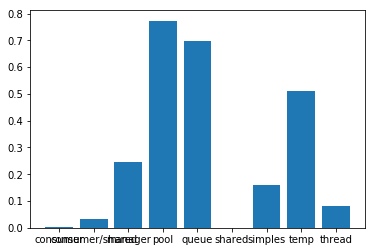

In [13]:
y = [
    max(msolucao1.mem_usage) - msolucao1.baseline,
    max(msolucao2.mem_usage) - msolucao2.baseline,
    max(msolucao3.mem_usage) - msolucao3.baseline,
    max(msolucao4.mem_usage) - msolucao4.baseline,
    max(msolucao5.mem_usage) - msolucao5.baseline,
    max(msolucao6.mem_usage) - msolucao6.baseline,    
    max(msolucao7.mem_usage) - msolucao7.baseline,
    max(msolucao8.mem_usage) - msolucao8.baseline,
    max(msolucao9.mem_usage) - msolucao9.baseline,
]
x = ['simples', 'thread', 'pool', 'queue', 'temp', 'manager', 'shared', 'consumer', 'consumer/shared']
plt.bar(x, y)

#### Conclusão

A abordagem que apresentou melhores resultados foi a de rodar em paralelo usando mémoria compartilhada para armazenar os resultados dos processos. Uma abordagem com threads pode ser aplicada se o ambiente só apresentar apenas um processador.